# EDA

## Imports

In [1]:
import dask.bag as db
import pandas as pd
import json
import matplotlib.pyplot as plt
import ast
from collections import Counter

## Data Loading & Sampling

In [2]:
# Get approximate random sample 
sample = (db.read_text('arxiv-metadata-oai-snapshot.json')
          .map(json.loads)
          .random_sample(0.1)  # 10% sample (approximately 200,000)
          .compute())

df = pd.DataFrame(sample)  

In [3]:
print(f"Total papers: {len(df)}")
print(f"Columns available: {df.columns.tolist()}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Total papers: 272346
Columns available: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'abstract', 'versions', 'update_date', 'authors_parsed']

Data types:
id                object
submitter         object
authors           object
title             object
comments          object
journal-ref       object
doi               object
report-no         object
categories        object
license           object
abstract          object
versions          object
update_date       object
authors_parsed    object
dtype: object

Missing values:
id                     0
submitter           1501
authors                0
title                  0
comments           70500
journal-ref       182871
doi               148137
report-no         253467
categories             0
license            45629
abstract               0
versions               0
update_date            0
authors_parsed         0
dtype: int64


## Data Inspection

#### Results:
Total papers: 272,346\
Columns (14):\
id, submitter, authors, title, comments, journal-ref, doi, report-no, categories, license, abstract, versions, update_date, authors_parsed

#### Data Types:
All columns stored as object (strings)

## 📊 Analyzing Publication Trends Over Time

In this section, we analyze how the number of publications has changed over the years using the `update_date` field in our dataset.

### 🧾 Step 1: Convert Dates to Datetime Format

We first convert the `update_date` column from string format to pandas' `datetime` format. This enables us to easily extract and manipulate date components like the year, month, etc.

### 📅 Step 2: Extract the Year from Each Date

We create a new column called year by extracting the year part from each update_date. This helps us group publications by year.

### 📈 Step 3: Count Publications Per Year

Here, we count how many publications occurred in each year using value_counts(). We then sort the years in chronological order using sort_index() to ensure the bar chart is properly aligned by year.

### 📊 Step 4: Plot the Publication Trends

We use a bar chart to visualize the number of publications per year. The figsize is set to make the chart large and readable. Labels and a title are added for clarity.


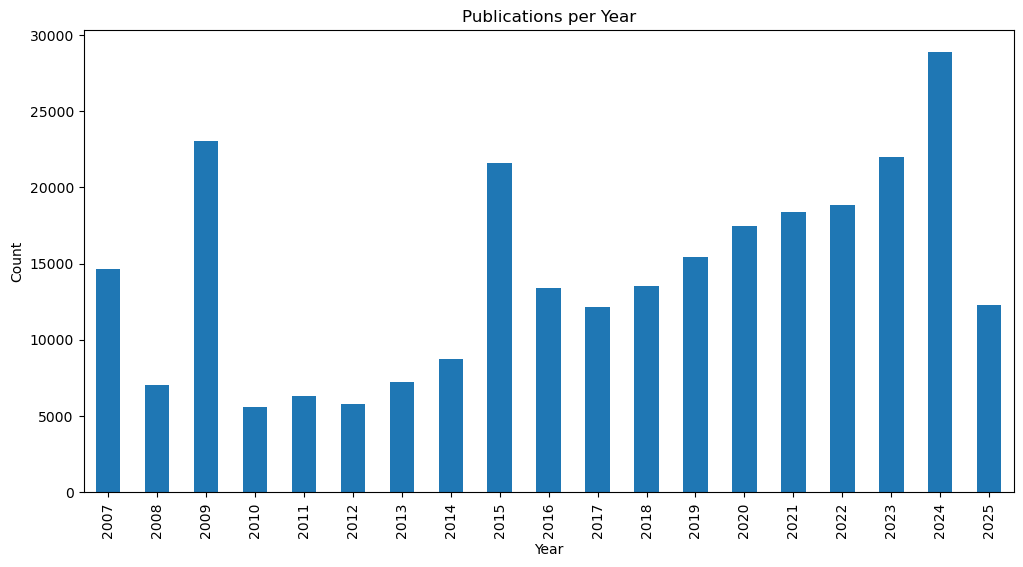

In [4]:
# Convert dates
df['update_date'] = pd.to_datetime(df['update_date'])

# Yearly publications
df['year'] = df['update_date'].dt.year
yearly_counts = df['year'].value_counts().sort_index()

# Plot publication trends
plt.figure(figsize=(12,6))
yearly_counts.plot(kind='bar')
plt.title('Publications per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

## 🔍 Interpretation of the Chart

The bar chart shows significant variation in the number of publications per year:
* Spikes in years like 2009, 2015, and 2024 suggest periods of increased activity. This may be due to increased intrest in certain fields such as AI or high energy physics which makes up a large portion of the submissions

* The dip in 2025 occurs as the year is ongoing

* Aside from these spikes there is a clear linear trend upwards suggesting either increased research output or increased popularity of Arxiv. This biases the data towards more recent papers which should not have any negative effects on the summarization model as it is inteded to be used on current research papers.

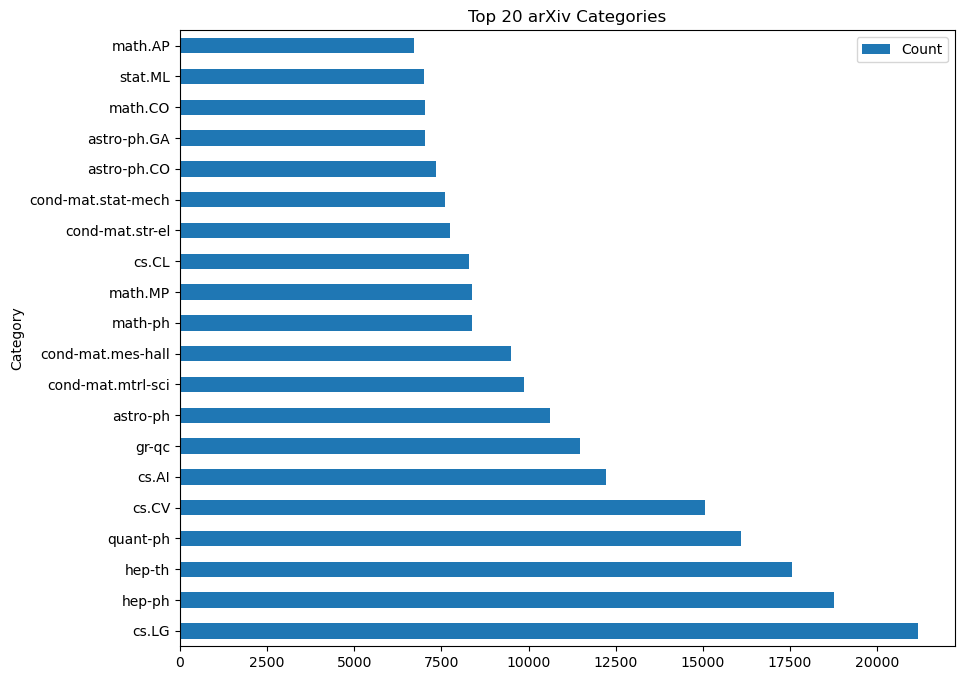

In [5]:
# Split categories (papers often have multiple)
df['categories_list'] = df['categories'].str.split()

# Get flattened list of all categories
all_categories = [cat for sublist in df['categories_list'] for cat in sublist]

# Top categories
top_cats = Counter(all_categories).most_common(20)

# Plot
pd.DataFrame(top_cats, columns=['Category','Count']).set_index('Category').plot.barh(figsize=(10,8))
plt.title('Top 20 arXiv Categories')
plt.show()

### 📈 Interpretation of the Chart

The horizontal bar chart shows the 20 most frequent research categories on arXiv. Here are some key takeaways:

- **cs.LG** *(Machine Learning)* is the most common category, reflecting the exponential growth of machine learning research.
- Other top categories include:
  - **hep-ph / hep-th** – High-energy physics (phenomenology and theory).
  - **quant-ph** – Quantum physics.
  - **cs.CV** – Computer vision.
  - **cs.AI** – Artificial intelligence.
  - **gr-qc** – General relativity and quantum cosmology.
  - **astro-ph** – Astrophysics-related fields.
- Several **condensed matter physics** and **mathematics** categories (e.g., `math-ph`, `math.CO`, `stat.ML`) are also well-represented.



## 👥 Author Count Analysis

Before training our text summarization model, it's useful to understand patterns in the metadata of the arXiv papers. One such feature is the **number of authors per paper**, which may correlate with abstract length, writing style, or field of study.


In [7]:
# Count authors per paper
df['num_authors'] = df['authors_parsed'].apply(len)
df['num_authors'].describe()

count    272346.000000
mean          4.645543
std          24.095466
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max        1941.000000
Name: num_authors, dtype: float64

### 📈 Interpretation

- The **average paper** has about **4–5 authors**.
- The **majority of papers** (up to the 75th percentile) have **4 or fewer authors**.
- However, the **maximum value of 1,941 authors** is a strong outlier. This likely comes from papers authored by large collaborations (e.g., in **high-energy physics** or **astronomy**).
- The **standard deviation** is quite large (**24.10**), further confirming the presence of significant outliers.

- Papers with more authors may use **more technical or collaborative writing styles**, which could influence **abstract structure and content**.
- Understanding author count distributions can help in:
  - **Filtering out extreme outliers** that may skew model training.
  - **Adding author count as a feature** if we decide to use **metadata in our summarization model**.


### 🔍 What This Code Does
- Filters the dataset to include only papers with **50 or fewer authors**, removing extreme outliers that would distort the plot.
- Counts how often each author count appears (`value_counts()`), sorts these counts by the number of authors (`sort_index()`), and plots a **bar chart**.
- Labels axes and adds a grid for better readability.


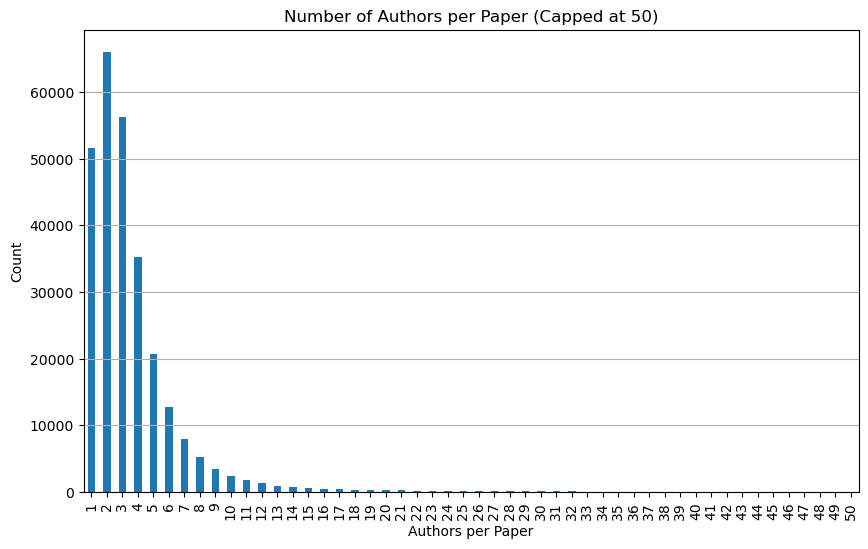

In [17]:
plt.figure(figsize=(10,6))
df[df['num_authors'] <= 50]['num_authors'].value_counts().sort_index().plot.bar()
plt.title('Number of Authors per Paper (Capped at 50)')
plt.xlabel('Authors per Paper')
plt.ylabel('Count')
plt.grid(True, axis='y')
plt.show()

### 📈 Interpretation of the Chart
- The chart shows that most papers have a **small number of authors**, with peaks around **2–4 authors**.
- Author counts gradually **taper off**, with papers having more than 10 authors becoming increasingly rare.
- By **capping at 50**, we capture the **long tail** of collaborative papers without allowing extreme values (like 100+ authors) to compress the scale.
- This **clearer view** helps us better understand typical collaboration patterns.


### 🧠 Why This Matters
- This cleaned view of the author distribution gives a **realistic picture** of authorship patterns, useful for **preprocessing** or **feature engineering**.
- If extreme author counts are used as model features (e.g., in a summarization model), they might need **normalization or clipping**.
- It also hints that **writing style and abstract complexity** may differ between small-team and large-team papers — a useful insight for modeling.


### 🔍 What This Code Does

- **Converts author names to tuples** so they can be counted (tuples are hashable, lists are not).
- Flattens all the author entries across papers into a single list called `all_authors`.
- Uses Python’s `collections.Counter` to **count the number of times each author appears** across the dataset.
- Extracts the **top 20 most frequent authors** and prints their name and paper count.


In [9]:
# Convert author lists to tuples (which are hashable) for counting
all_authors = []
for author_list in df['authors_parsed']:
    if isinstance(author_list, list):
        all_authors.extend([tuple(author) for author in author_list])

# Count and get top 20
from collections import Counter
top_authors = Counter(all_authors).most_common(20)

# Display results
print("\nTop 20 Authors:")
for i, (author, count) in enumerate(top_authors, 1):
    print(f"{i}. {' '.join(author)}: {count} papers")


Top 20 Authors:
1. Zhang Y. : 290 papers
2. Wang J. : 239 papers
3. Liu Yang : 210 papers
4. Wang Z. : 198 papers
5. Li Y. : 195 papers
6. Wang Y. : 181 papers
7. Wang Wei : 167 papers
8. Gao Y. : 167 papers
9. Xu Z. : 165 papers
10. Liu X. : 164 papers
11. Taniguchi Takashi : 164 papers
12. Yang Z. : 157 papers
13. Watanabe Kenji : 156 papers
14. Zhang L. : 154 papers
15. Liu Y. : 153 papers
16. Zhang Wei : 143 papers
17. Zhang Lei : 142 papers
18. Zhang J. : 140 papers
19. CMS Collaboration  : 138 papers
20. Sun L. : 137 papers


### 📈 Interpretation of the Output

- The output lists the **top 20 most prolific authors** (or author entries) on arXiv in terms of number of papers.
- Some entries (e.g., *CMS Collaboration*) reflect **large research groups or consortia**, especially in high-energy physics.
- Several authors have **over 150 papers**, suggesting very active publication rates — possibly due to multiple co-authorships or group authorship practices.

### 🧠 Why This Matters

- Understanding author frequency helps reveal **influential contributors or prolific research groups** in the dataset.
- Highlights the issue of **name disambiguation**, where authors with similar or identical names might be conflated.
- Knowing the dominant contributors can guide:
  - Data cleaning (e.g., merging author variants).
  - Feature engineering (e.g., encoding prolific authors).
  - Model analysis, if summarization quality varies by author.

### 🔍 What This Code Does

- **Single vs Multi-Author Analysis**:
  - Calculates the proportion of papers written by a **single author**.

- **Top Collaboration Sizes**:
  - Uses `value_counts(normalize=True)` to find the **most common numbers of authors**.
  - Displays the **top 10 most frequent team sizes** as proportions.

- **Field-Specific Authorship Analysis**:
  - Extracts the **primary category** (first listed label) for each paper.
  - Computes and sorts the **average number of authors per paper** by field.

In [19]:
# Single vs multi-author papers
single_author = (df['num_authors'] == 1).mean()
print(f"\nSingle-author papers: {single_author:.1%}")

# Top collaboration sizes
print("\nMost common collaboration sizes:")
print(df['num_authors'].value_counts(normalize=True).head(10))

# Field-specific analysis 
df['primary_category'] = df['categories'].str.split().str[0]
print("\nAverage authors per paper by field:")
print(df.groupby('primary_category')['num_authors'].mean().sort_values(ascending=True))


Single-author papers: 19.0%

Most common collaboration sizes:
num_authors
2     0.242412
3     0.206535
1     0.189575
4     0.129659
5     0.076142
6     0.046977
7     0.029242
8     0.019093
9     0.012653
10    0.008831
Name: proportion, dtype: float64

Average authors per paper by field:
primary_category
physics.hist-ph     1.483384
acc-phys            1.500000
physics.gen-ph      1.523282
alg-geom            1.534884
funct-an            1.542857
                     ...    
astro-ph.IM        13.424227
astro-ph.HE        15.325818
physics.ins-det    15.900068
nucl-ex            23.866264
hep-ex             60.814614
Name: num_authors, Length: 171, dtype: float64


### 📈 Interpretation of the Output

- **Single-author papers** account for **19.0%** of the dataset. Most research on arXiv involves collaboration.

- **Most frequent team sizes**:
  - 2 authors → **24.2%**
  - 3 authors → **20.7%**
  - 1 author → **18.9%**
  - 4–6 authors still fairly common, but drop sharply after that.

- **Field-specific patterns**:
  - Fields like *History and Philosophy of Physics*, *General Mathematics*, and *algebraic geometry* average **~1.5 authors**, indicating more **individual or small-group research**.
  - Fields like *high energy physics experiment*, *Nuclear Expreiments*, and *High Energy Astrophysical Phenomena* average **15–60 authors**, indicating **massive collaborations**, typical of high-energy physics or astrophysics.

### 🧠 Why This Matters

- Fields with **very different collaboration norms** likely have very different **writing styles**, structures, and levels of technical detail.
- Knowing these norms helps when:
  - **Engineering features** (e.g., author count or field).
  - **Normalizing outliers** for model training.
  - **Adapting summarization models** to field-specific language patterns.
- For example, summaries from high-energy physics may require handling **institutional author groups** and **dense technical prose**, unlike those from solo mathematics authors.




Abstract length stats:
count    272346.000000
mean        972.072147
std         431.129516
min          14.000000
25%         638.000000
50%         943.000000
75%        1282.000000
max        4087.000000
Name: abstract_length, dtype: float64


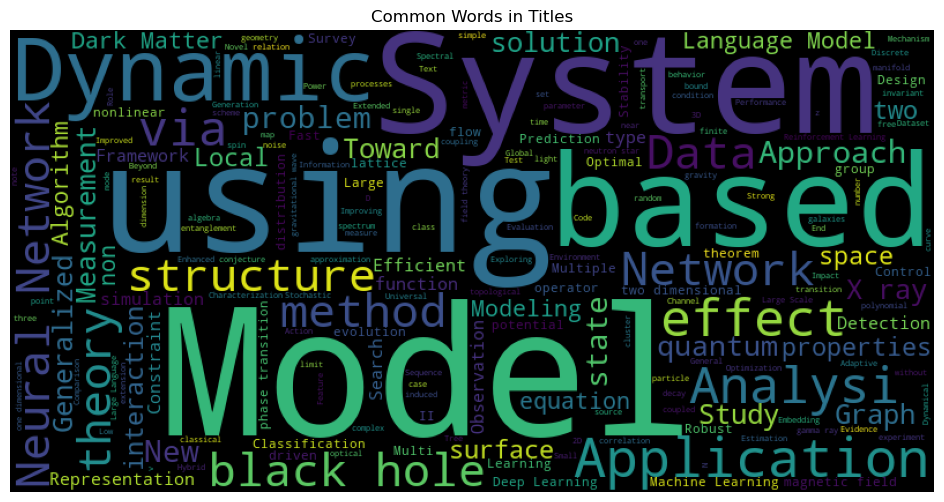

In [11]:
# Abstract length analysis
df['abstract_length'] = df['abstract'].str.len()
print("\nAbstract length stats:")
print(df['abstract_length'].describe())

# Word clouds
from wordcloud import WordCloud

# Titles word cloud
title_text = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400).generate(title_text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common Words in Titles')
plt.show()

### 📊 Abstract Length Analysis

- The length of each abstract (in characters) was computed using `str.len()`.
- Summary statistics:

  | Metric       | Value    |
  |--------------|----------|
  | Count        | 272,346  |
  | Mean         | 972      |
  | Std Dev      | 431      |
  | Min          | 14       |
  | 25th Percentile | 638   |
  | Median       | 943      |
  | 75th Percentile | 1,282 |
  | Max          | 4,087    |

- **Interpretation**:
  - Most abstracts range from ~600 to ~1300 characters.
  - A few papers have **very short** or **very long** abstracts, suggesting possible errors or unusually terse/verbose summaries.
  - These values can inform **truncation or padding strategies** for NLP models.

### ☁️ Word Cloud of Title Texts

- A word cloud was generated from all paper titles using the `WordCloud` library.
- Common prominent words included:

  * **Dynamic**, **System**, **Using**, **Based**, **Model**, **Effect**,  
  * **Analysis**, **Network**, **Structure**, **Black Hole**, **Application**,  
  * **Quantum**, **Theory**, **Representation**

- **Interpretation**:
  - Titles emphasize **methodology** (e.g., “based”, “using”, “model”), **scientific domains** (e.g., “quantum”, “network”, “structure”), and **concepts** (e.g., “theory”, “effect”).
  - This reflects a strong presence of papers in physics, computer science, and engineering.

### 🧠 Why This Matters

- Abstract length is a useful **feature** for quality filtering, token budgeting, or model tuning.
- Word clouds help:
  - Reveal dominant **research themes**.
  - Spot **common jargon** for field-specific tokenization or embeddings.
  - Understand what makes a good or typical arXiv title.
